# Data analysis pipeline on Onyxia

Configure the Onyxia service for directly cloning the repository

- add token in personnal parameters
- indicate the repository in the service configuration

## 1. Connect to personnal S3 and load data

In [1]:
import s3fs
import os

fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'https://'+os.environ["AWS_S3_ENDPOINT"]},
                       key = os.environ["AWS_ACCESS_KEY_ID"], 
                       secret = os.environ["AWS_SECRET_ACCESS_KEY"], 
                       token = os.environ["AWS_SESSION_TOKEN"])

fs.ls("eschultz-ensae")

['eschultz-ensae/full3cat1103.csv', 'eschultz-ensae/full3cat1103.parquet']

Parquet datafile of 1Gb

### Dask

In [5]:
import dask.dataframe as dd
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
 
df=dd.read_parquet("s3a://eschultz-ensae/full3cat1103.parquet",  storage_options={
        "client_kwargs": {
            "endpoint_url": S3_ENDPOINT_URL,
        }})
print(len(df))
df.head()

7148986


,id,timestamp_utc,local_time,user_screen_name,text,retweet_count,like_count,reply_count,to_username,to_userid,...,sexe,slug,nom_circo,groupe_sigle,mp_follower,mp_tweets,crit_label,crit_proba,support_label,support_proba
0,European Haut-Savoyard.,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1574104237935665156,1664130670,2022-09-25 20:31:10,JordanMartel10,@ALeaument Les iraniens luttent contre l’islam...,0.0,0.0,0.0,ALeaument,112103858.0,...,H,antoine-leaument,Essonne,LFI,67076,37237,1,0.90979654,0,0.9626039
2,1565695709168508934,1662125920,2022-09-02 15:38:40,Eric_vds,@alexiscorbiere par définition le Conseil de D...,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1574722509324587008,1664278077,2022-09-27 13:27:57,jeanraminon,@MathildePanot la France a déjà le record du m...,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1565370150148358147,1662048301,2022-09-01 18:05:01,UnhommeenFrance,@GuiraudInd Parce qu’il n’ont pas la responsab...,5.0,0.0,0.0,GuiraudInd,427246481.0,...,H,david-guiraud,Nord,LFI,111873,6106,0,0.8422544,0,0.96134514


## Pandas

In [7]:
import pandas as pd

S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]

df = pd.read_parquet("s3a://eschultz-ensae/full3cat1103.parquet",storage_options={
        "client_kwargs": {
            "endpoint_url": S3_ENDPOINT_URL,
        }})
df.shape

(7148986, 40)

In [8]:
df_test = df["text"].head()
df_test

0                                                 None
1    @ALeaument Les iraniens luttent contre l’islam...
2    @alexiscorbiere par définition le Conseil de D...
3    @MathildePanot la France a déjà le record du m...
4    @GuiraudInd Parce qu’il n’ont pas la responsab...
Name: text, dtype: object

## 2. Topic analysis

### 2.1 Cleaning

In [72]:
def remove_initial_users(text):
    """
    Cleaning function
    """
    if text is None:
        return None
    if len(text)<50:
        return None
    text = text.split()
    c = 0
    for i in text:
        if i[0]=="@":
            c+=1
        else:
            break
    return " ".join([i for i in text[c:] if not "http" in i])

In [73]:
df["texte_cleaned"] = df["text"].apply(remove_initial_users)

In [74]:
df["texte_cleaned"]

0                                                       None
1          Les iraniens luttent contre l’islamisation dan...
2          par définition le Conseil de Défense est restr...
3                        la France a déjà le record du monde
4          Parce qu’il n’ont pas la responsabilité de plu...
                                 ...                        
7148981                                                 None
7148982                                                     
7148983                                                 None
7148984              Tu doit rendre ton écharpe de député 🇫🇷
7148985                                                 None
Name: texte_cleaned, Length: 7148986, dtype: object

### BERTOPIC

https://maartengr.github.io/BERTopic/index.html

In [28]:
#df[["texte_cleaned"]][0:10000].to_parquet("sample.parquet")

In [103]:
sample = df["texte_cleaned"].sample(10000).dropna().drop_duplicates()
sample

6869307           Cela fait vachement avancer le schmilblick
2851434    Connasse n’a rien compris à cette plante médic...
7085953    Quand on connaît le personnage, pas étonnant :...
1065768    Et c'est un islamo-gaucho-ecolo-progressistes ...
1688312       « aux Français »… retournez donc à l’école!!!🤣
                                 ...                        
6612423    Pourtant, pour venir en France faire la promot...
332558     🤮🤮complétement absurde! La folie des hommes n'...
157473          Pas si près on sent votre haleine fétide…🤮🤮🤮
6454760    Il ne semble pas avoir très envie de s’arrêter...
3571964    "@LouisBoyard 2,3 millions selon les ""experts...
Name: texte_cleaned, Length: 4704, dtype: object

In [104]:
%%time
from bertopic import BERTopic
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
dim_model = PCA(n_components=5)
hdbscan_model = HDBSCAN(min_cluster_size=20, 
                        metric='euclidean', 
                        cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(verbose=True, language="french")
topics, probs = topic_model.fit_transform(sample)

2024-05-01 19:45:01,324 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/147 [00:00<?, ?it/s]

2024-05-01 19:45:23,152 - BERTopic - Embedding - Completed ✓
2024-05-01 19:45:23,154 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-05-01 19:47:16,104 - BERTopic - Dimensionality - Completed ✓
2024-05-01 19:47:16,106 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-05-01 19:47:16,402 - BERTopic - Cluster - Completed ✓
2024-05-01 19:47:16,408 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-05-01 19:47:16,736 - BERTopic - Representation - Completed ✓


CPU times: user 1h 1min 36s, sys: 41.4 s, total: 1h 2min 17s
Wall time: 2min 16s


In [105]:
topic_model.get_topic_info()[0:10]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1937,-1_vous_de_le_et,"[vous, de, le, et, la, est, les, pas, que, un]",[C’est ça ton boulot ? Et macron il te va bien...
1,0,509,0_français_france_la_de,"[français, france, la, de, les, en, et, des, e...",[J'arrive pas à comprendre. Vous faites de la ...
2,1,132,1_retraites_ans_retraite_réforme,"[retraites, ans, retraite, réforme, des, systè...",[C’est cette réforme des retraites qui est ina...
3,2,119,2_argent_riches_millions_de,"[argent, riches, millions, de, qui, les, plus,...",[Au lieu de plaindre des privilégiés qui gagne...
4,3,100,3_macron_voté_voter_vous,"[macron, voté, voter, vous, pour, de, est, pas...",[Vous avez voté pour Macron .... sans conditio...
5,4,83,4_élections_voter_vous_électeurs,"[élections, voter, vous, électeurs, vote, réfé...",[La nupes l'escroquerie gauchiste par excellen...
6,5,75,5_sandrousseau_aleaument_mathildepanot_louisbo...,"[sandrousseau, aleaument, mathildepanot, louis...",[« Celine_Leger_FI: « Ceux qui ont pris tout l...
7,6,73,6_point_rame_allez_merci,"[point, rame, allez, merci, ça, petite, poches...","[Vous, vu votre niveau, on peut vous prédire u..."
8,7,61,7_vous_avez_oublié_je,"[vous, avez, oublié, je, mon, tu, aviez, été, ...",[Ce qui signifie bien si vous l’aviez oublié q...
9,8,61,8_femmes_hommes_violences_femme,"[femmes, hommes, violences, femme, féminisme, ...",[On attend que les féministes se battent pour ...


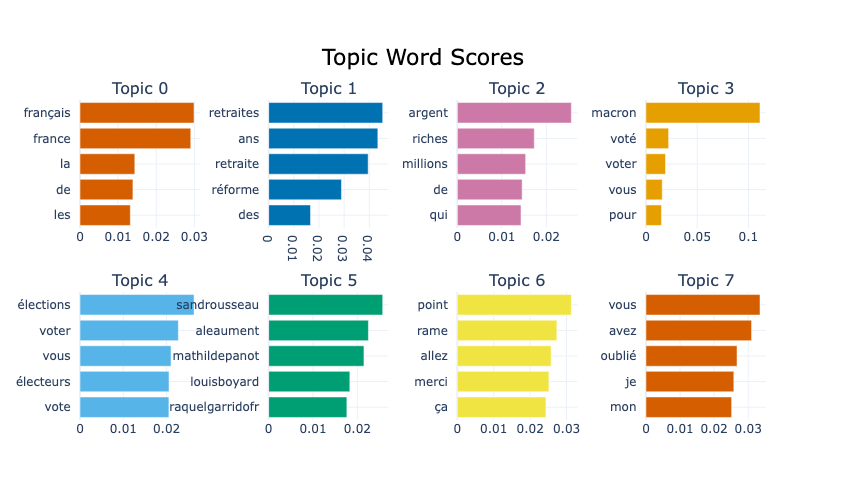

In [106]:
topic_model.visualize_barchart()

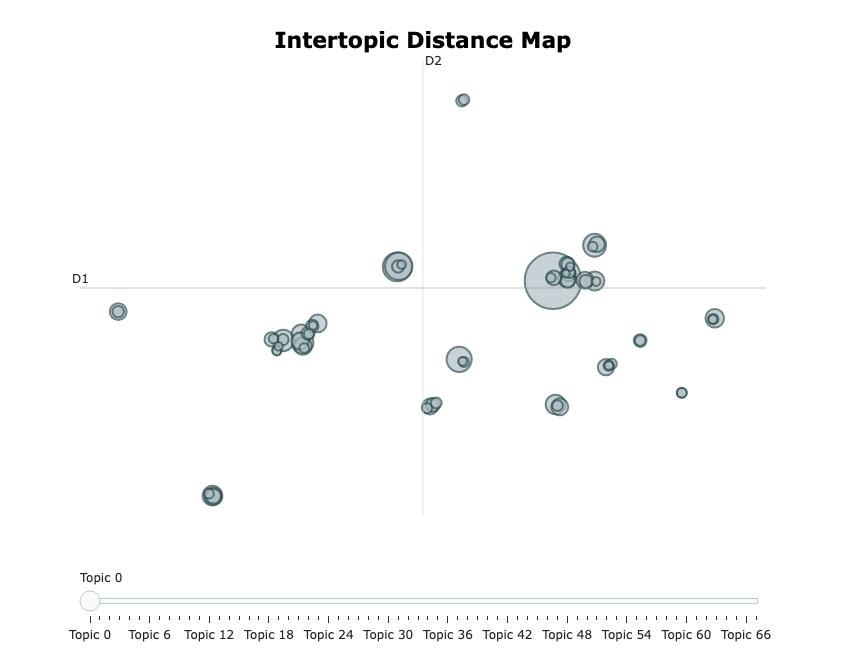

In [107]:
topic_model.visualize_topics()